#### Setup up environment
```
conda create -n motile -c conda-forge -c gurobi -c funkelab ilpy
conda activate motile
pip install git+https://github.com/funkelab/motile structsvm matplotlib
```

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

import motile

#### Routines to draw graph

In [2]:
from motile.variables import NodeSelected, EdgeSelected
def draw_track_graph(
    graph,
    solver=None,
    color="purple",
    selected=None, 
    selected_fn=lambda x: x,
    fig=None):
    
    frames = list(range(*graph.get_frames()))
    
    graph = graph.nx_graph  # use old networkx-based routines
    num_nodes = graph.number_of_nodes()

    positions = {
        node: (data['t'], data['x'])
        for node, data in graph.nodes(data=True)
    }

    colors = [color] * num_nodes

    if solver is not None:
        node_indicators = solver.get_variables(NodeSelected)
        edge_indicators = solver.get_variables(EdgeSelected)
        selected = 'selected'
        
        for node, index in node_indicators.items():
            graph.nodes[node]['selected'] = solver.solution[index] > 0.5
        for edge, index in edge_indicators.items():
            graph.edges[edge]['selected'] = solver.solution[index] > 0.5
        

            
    
    alpha_attribute = 'score' if solver is None and selected is None else selected
    node_alphas = [
        selected_fn(data[alpha_attribute] if alpha_attribute in data else None)
        for _, data in graph.nodes(data=True)
    ]
    edge_alphas = [
        selected_fn(data[alpha_attribute] if alpha_attribute in data else None)
        for _, _, data in graph.edges(data=True)
    ]

    node_labels = {
        node: data['score']
        for node, data in graph.nodes(data=True)
      }
    edge_labels = {
        (u, v): data['score']
        for u, v, data in graph.edges(data=True)
    }

    if fig is None:
        fig = plt.figure()
        fig.set_figheight(4)
        fig.set_figwidth(8)

    nx.draw_networkx_nodes(
        graph,
        positions,
        alpha=node_alphas,
        node_size=600,
        linewidths=2.0,
        node_color=colors)
    if solver is None and selected is None:
        nx.draw_networkx_labels(
            graph,
            positions,
            node_labels)
    nx.draw_networkx_edges(
        graph,
        positions,
        alpha=edge_alphas,
        width=3.0,
        arrowsize=20,
        node_size=600,
        min_source_margin=20,
        min_target_margin=20,
        edge_color=color)
    if solver is None and selected is None:
        nx.draw_networkx_edge_labels(
            graph,
            positions,
            edge_labels,
            label_pos=0.3)

    plt.xlabel("time")
    plt.ylabel("space")
    plt.grid(True)
    plt.xticks(frames, frames)
    
    return fig

In [3]:
def draw_groundtruth_graph(graph, gt_attribute="gt"):
    """
    green: ground_truth pos
    orange: ground truth neg
    gray: don't care.
    """
    fig = draw_track_graph(graph, color="green", selected=gt_attribute, selected_fn=lambda x: x == 1)
    fig = draw_track_graph(graph, color="darkorange", selected=gt_attribute, selected_fn=lambda x: x == 0, fig=fig)
    fig = draw_track_graph(graph, color="gray", selected=gt_attribute, selected_fn=lambda x: x is None, fig=fig)
    
    return fig

#### Define graph

In [4]:
def create_toy_example_graph():
    cells = [
        {"id": 0, "t": 0, "x": 1, "score": 0.8, "gt": 1},
        {"id": 1, "t": 0, "x": 25, "score": 0.1},
        {"id": 2, "t": 1, "x": 0, "score": 0.3, "gt": 1},
        {"id": 3, "t": 1, "x": 26, "score": 0.4},
        {"id": 4, "t": 2, "x": 2, "score": 0.6, "gt": 1},
        {"id": 5, "t": 2, "x": 24, "score": 0.3, "gt": 0},
        {"id": 6, "t": 2, "x": 35, "score": 0.7},
    ]

    edges = [
        {"source": 0, "target": 2, "score": 0.9, "gt": 1},
        {"source": 1, "target": 3, "score": 0.9},
        {"source": 0, "target": 3, "score": 0.5},
        {"source": 1, "target": 2, "score": 0.5},
        {"source": 2, "target": 4, "score": 0.7, "gt": 1},
        {"source": 3, "target": 5, "score": 0.7},
        {"source": 2, "target": 5, "score": 0.3, "gt": 0},
        {"source": 3, "target": 4, "score": 0.3},
        {"source": 3, "target": 6, "score": 0.8},
    ]
    graph = nx.DiGraph()
    graph.add_nodes_from([(cell["id"], cell) for cell in cells])
    graph.add_edges_from([(edge["source"], edge["target"], edge) for edge in edges])
    return motile.TrackGraph(graph)

#### Example candidate graph

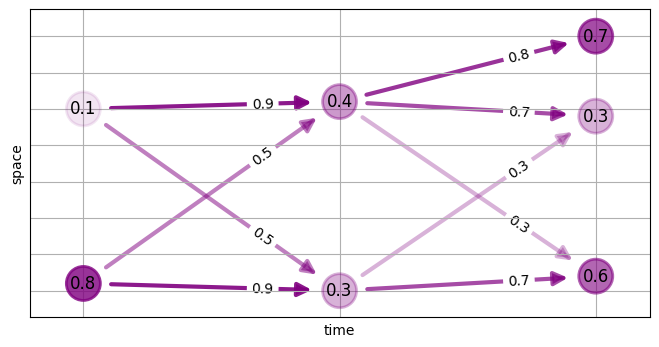

In [5]:
graph = create_toy_example_graph()
fig = draw_track_graph(graph)

#### Ground truth
We have a ground truth for this candidate graph, which we display in the following way:
- green: select
- orange: do not select
- gray: unknown whether it should be selected 

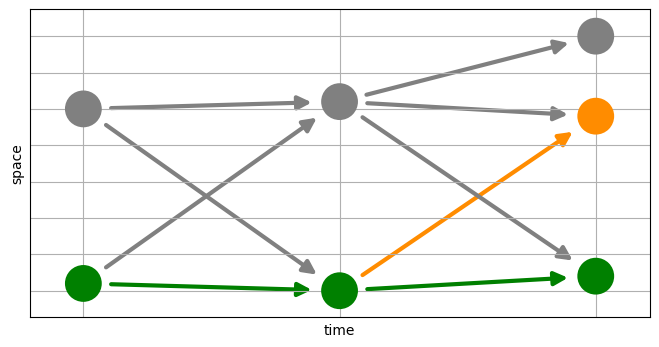

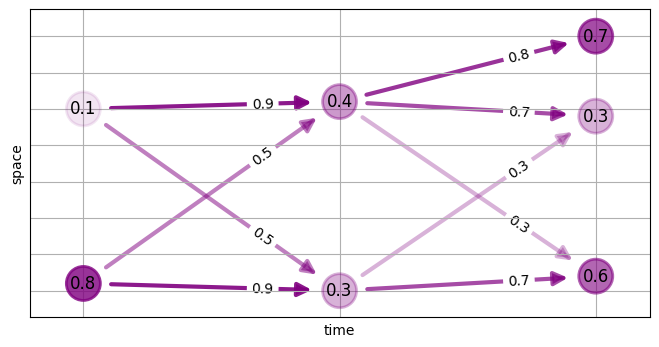

In [6]:
fig_gt = draw_groundtruth_graph(graph)
fig = draw_track_graph(graph)

#### Solver setup

In [7]:
from motile.constraints import MaxParents, MaxChildren
from motile.costs import NodeSelection, EdgeSelection, Appear

def create_solver(graph):
    solver = motile.Solver(graph)

    solver.add_constraints(MaxParents(1))
    solver.add_constraints(MaxChildren(1))

    solver.add_costs(NodeSelection(weight=1, attribute="score"))
    solver.add_costs(EdgeSelection(weight=-2, attribute="score", constant=1))
    solver.add_costs(Appear(constant=1))
    
    return solver
    
initial_solver = create_solver(graph)
print("====== Initial Weights ======")
print(initial_solver.weights)

INFO:motile.solver:Adding SelectEdgeNodes constraints...
INFO:motile.solver:Adding NodeSelected variables...
INFO:motile.solver:Adding EdgeSelected variables...
INFO:motile.solver:Adding MaxParents constraints...
INFO:motile.solver:Adding MaxChildren constraints...
INFO:motile.solver:Adding NodeSelection costs...
INFO:motile.solver:Adding EdgeSelection costs...
INFO:motile.solver:Adding Appear costs...
INFO:motile.solver:Adding NodeAppear variables...


====== Initial Weights ======
('NodeSelection', 'weight') = 1
('NodeSelection', 'constant') = 0.0
('EdgeSelection', 'weight') = -2
('EdgeSelection', 'constant') = 1
('Appear', 'constant') = 1



#### Let's solve the ILP with our arbitrarily chosen weights

INFO:motile.solver:Computing costs...
INFO:motile.solver:ILP solver returned with: b'Optimal solution found'


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-05
NodeSelected(0): cost=0.800000011920929 value=-0.0
NodeSelected(1): cost=0.10000000149011612 value=1.0
NodeSelected(2): cost=0.30000001192092896 value=0.0
NodeSelected(3): cost=0.4000000059604645 value=1.0
NodeSelected(4): cost=0.6000000238418579 value=0.0
NodeSelected(5): cost=0.30000001192092896 value=1.0
NodeSelected(6): cost=0.699999988079071 value=0.0
EdgeSelected((0, 2)): cost=-0.7999999523162842 value=0.0
EdgeSelected((0, 3)): cost=0.0 value=0.0
EdgeSelected((1, 3)): cost=-0.7999999523162842 value=1.0
EdgeSelected((1, 2)): cost=0.0 value=0.0
EdgeSelected((2, 4)): cost=-0.3999999761581421 value=0.0
EdgeSelected((2, 5)): cost=0.3999999761581421 value=0.0
EdgeSelected((3, 5)): cost=-0.3999999761581421 value=1.0
EdgeSelected((3, 4)): cost=0.3999999761581421 value=0.0
EdgeSelected((3, 6)): cost=-0.6000000238418579 value=0.0


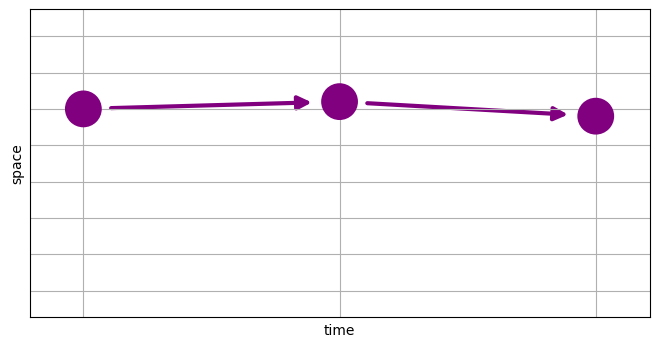

In [8]:
solution = initial_solver.solve()
print(initial_solver.get_variables(NodeSelected))
print(initial_solver.get_variables(EdgeSelected))
fig = draw_track_graph(graph, initial_solver)

#### Update the weights manually

In [9]:
print("====== Initial Weights ======")
print(initial_solver.weights)

====== Initial Weights ======
('NodeSelection', 'weight') = 1
('NodeSelection', 'constant') = 0.0
('EdgeSelection', 'weight') = -2
('EdgeSelection', 'constant') = 1
('Appear', 'constant') = 1



INFO:motile.solver:Weights have changed
INFO:motile.solver:Computing costs...
INFO:motile.solver:ILP solver returned with: b'Optimal solution found'


Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-05
====== Updated Weights ======
('NodeSelection', 'weight') = 1
('NodeSelection', 'constant') = 0.0
('EdgeSelection', 'weight') = -3
('EdgeSelection', 'constant') = 1
('Appear', 'constant') = 0.5



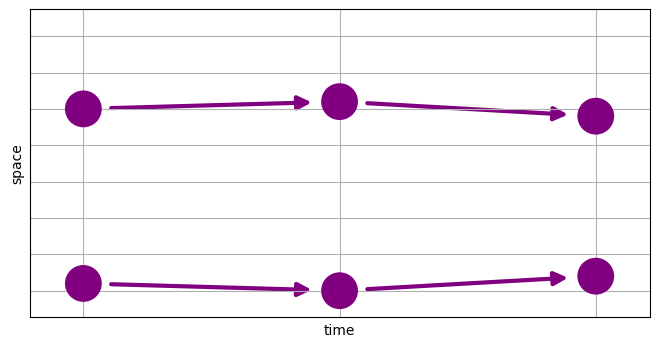

In [10]:
# initial_solver.weights[("NodeSelection", "weight")] = -1               
initial_solver.weights[("EdgeSelection", "weight")] = -3               
initial_solver.weights[("Appear", "constant")] = 0.5

solution = initial_solver.solve()
print("====== Updated Weights ======")
print(initial_solver.weights)
fig = draw_track_graph(graph, initial_solver)

#### Structured learning

Let's do structured learning to fit the weights to our ground truth

INFO:motile.solver:Adding SelectEdgeNodes constraints...
INFO:motile.solver:Adding NodeSelected variables...
INFO:motile.solver:Adding EdgeSelected variables...
INFO:motile.solver:Adding MaxParents constraints...
INFO:motile.solver:Adding MaxChildren constraints...
INFO:motile.solver:Adding NodeSelection costs...
INFO:motile.solver:Adding EdgeSelection costs...
INFO:motile.solver:Adding Appear costs...
INFO:motile.solver:Adding NodeAppear variables...
INFO:structsvm.bundle_method:----------------- iteration 1
INFO:structsvm.bundle_method:          ε   is: 162.999996
INFO:structsvm.bundle_method:----------------- iteration 2
INFO:structsvm.bundle_method:          ε   is: 82.483679
INFO:structsvm.bundle_method:----------------- iteration 3
INFO:structsvm.bundle_method:          ε   is: 23.824748
INFO:structsvm.bundle_method:----------------- iteration 4
INFO:structsvm.bundle_method:          ε   is: 3.896371
INFO:structsvm.bundle_method:----------------- iteration 5
INFO:structsvm.bundle

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-05
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-05
====== Learnt Weights ======
('NodeSelection', 'weight') = -2.173912980292128
('NodeSelection', 'constant') = 0.8327760708747824
('EdgeSelection', 'weight') = -1.3043482754248852
('EdgeSelection', 'constant') = 0.5551840471248392
('Appear', 'constant') = 19.99999970211741

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-05


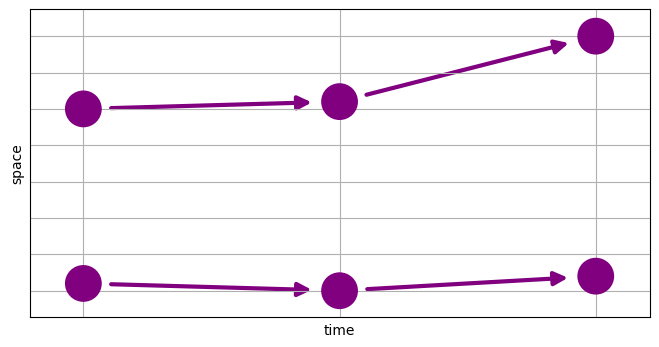

In [11]:
solver = create_solver(graph)
solver.fit_weights(gt_attribute="gt")


print("====== Learnt Weights ======")
optimal_weights = solver.weights
print(optimal_weights)

solver.solve()
# print(solver.get_variables(NodeSelected))
# print(solver.get_variables(EdgeSelected))
fig = draw_track_graph(graph, solver)

#### Let's use the learnt weights in a new solver

INFO:motile.solver:Adding SelectEdgeNodes constraints...
INFO:motile.solver:Adding NodeSelected variables...
INFO:motile.solver:Adding EdgeSelected variables...
INFO:motile.solver:Adding MaxParents constraints...
INFO:motile.solver:Adding MaxChildren constraints...
INFO:motile.solver:Adding NodeSelection costs...
INFO:motile.solver:Adding EdgeSelection costs...
INFO:motile.solver:Adding Appear costs...
INFO:motile.solver:Adding NodeAppear variables...
INFO:motile.solver:Computing costs...
INFO:motile.solver:ILP solver returned with: b'Optimal solution found'


====== Learnt Weights in new solver ======
('NodeSelection', 'weight') = -2.17391300201416
('NodeSelection', 'constant') = 0.8327760696411133
('EdgeSelection', 'weight') = -1.3043482303619385
('EdgeSelection', 'constant') = 0.5551840662956238
('Appear', 'constant') = 20.0

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-05


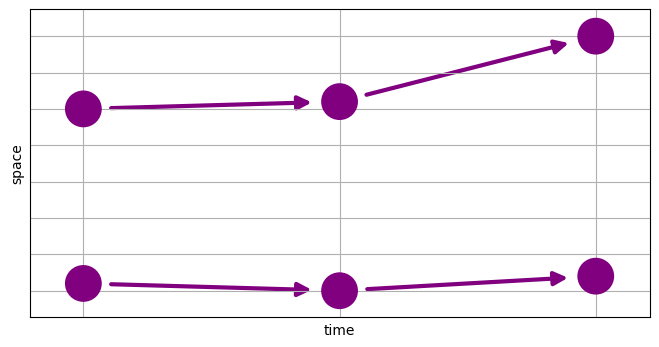

In [12]:
fitted_solver = create_solver(graph)
fitted_solver.weights.from_ndarray(optimal_weights.to_ndarray())
print("====== Learnt Weights in new solver ======")
print(fitted_solver.weights)

solution = fitted_solver.solve()
# print(fitted_solver.get_variables(NodeSelected))
# print(fitted_solver.get_variables(EdgeSelected))
fig = draw_track_graph(graph, fitted_solver)